### Introduction

- TODO

### Imports

In [1]:
import os
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, wasserstein_distance
from scipy.spatial.distance import jensenshannon

from joblib import Parallel, delayed
from utils import build_dict, isolate_option_types
from preprocessing import prepare_labels, build_features, add_datetime_features, add_advanced_features, tag_returns_process_group#, create_option_dataset_full
from constants import STOCK_PRICE_ABS_PATH, OPTIONS_CHAIN_ABS_PATH_MAP

In [2]:
exp_round = 2
n = 16
month = "01"
Xpath = f"/Volumes/T7/backup/Documents/perso/repos_perso/options-modeling/data/lgbm-train/exp_round{exp_round}/n{n}/X_{month}.csv"
ypath = f"/Volumes/T7/backup/Documents/perso/repos_perso/options-modeling/data/lgbm-train/exp_round{exp_round}/n{n}/y_{month}.csv"

In [3]:
stock_price_data = pd.read_csv(STOCK_PRICE_ABS_PATH)
with open(OPTIONS_CHAIN_ABS_PATH_MAP[month], "r") as f:
    options_chain_data = f.readlines()

In [4]:
raw_keys = options_chain_data[0]
options_hist_data = [
    item
    for raw_values in options_chain_data[1:]
    for item in isolate_option_types(build_dict(raw_keys, raw_values))
]
options_chain_data_hist = pd.DataFrame(options_hist_data)

In [5]:
options_chain_data_hist.loc[pd.isna(options_chain_data_hist["ask"])].shape, \
options_chain_data_hist.loc[(options_chain_data_hist["type"] == "call") & (options_chain_data_hist["ask"] == 0)].shape

((0, 20), (79, 20))

In [6]:
# options data manip
options_chain_data_hist_reduced = options_chain_data_hist.rename(columns={"quote_readtime": "datetime"})
call_chain_data_hist_reduced = options_chain_data_hist_reduced.loc[
    options_chain_data_hist_reduced["type"] == "call",
    ["datetime", "strike", "iv", "expire_date", "bid", "ask", "volume", "delta", "gamma", "vega", "theta", "rho"]
]
put_chain_data_hist_reduced = options_chain_data_hist_reduced.loc[
    options_chain_data_hist_reduced["type"] == "put",
    ["datetime", "strike", "iv", "expire_date", "bid", "ask", "volume", "delta", "gamma", "vega", "theta", "rho"]
]

# stocks data manip
stock_price_data_15min = stock_price_data.loc[stock_price_data["date"].apply(
    lambda x:(":30" in x[:-3]) or (":15" in x[:-3]) or (":00" in x[:-3]) or (":45" in x[:-3])
), ["date", "open", "volume"]]
stock_price_data_15min = stock_price_data_15min.rename(columns={"date": "datetime", "volume": "underlying_volume"})
stock_price_data_15min["datetime"] = stock_price_data_15min["datetime"].apply(lambda x: x[:-3])

# reset indexes
call_chain_data_hist_reduced = call_chain_data_hist_reduced.set_index("datetime")
put_chain_data_hist_reduced = put_chain_data_hist_reduced.set_index("datetime")
stock_price_data_15min = stock_price_data_15min.set_index("datetime")
concat_call_options_chain_prices = call_chain_data_hist_reduced.join(stock_price_data_15min, how="left")
concat_put_options_chain_prices = put_chain_data_hist_reduced.join(stock_price_data_15min, how="left")
concat_call_options_chain_prices = concat_call_options_chain_prices[concat_call_options_chain_prices.index.map(lambda x: " 16:00" not in x)]
df = concat_call_options_chain_prices.copy()
df.index = pd.to_datetime(df.index)
df = df.sort_index()

In [7]:
df.columns

Index(['strike', 'iv', 'expire_date', 'bid', 'ask', 'volume', 'delta', 'gamma',
       'vega', 'theta', 'rho', 'open', 'underlying_volume'],
      dtype='object')

In [7]:
df.loc[pd.isna(df["ask"])].shape, \
df.loc[df["ask"] == 0].shape

((0, 13), (79, 13))

In [ ]:
# Group the DataFrame
grouped = df.groupby(['strike', 'expire_date'])

# Process in parallel
results = Parallel(n_jobs=-1, backend='loky')(
    delayed(tag_returns_process_group)(strike, expire_date, group)
    for (strike, expire_date), group in grouped
)

# Combine results
df_labeled = pd.concat(results).sort_index()

# compute timestep delta from cumulative delta
df_labeled['date'] = df_labeled.index.date
df_labeled['delta_volume'] = (
    df_labeled.groupby(['date', 'strike', 'expire_date'])['volume']
    .diff()
    .fillna(0)
)

df_labeled = df_labeled.drop(columns=['date', 'volume'])
print(f"labels created for month {month}")

labels created for month 01


In [9]:
list(df_labeled.columns)

['strike',
 'iv',
 'expire_date',
 'bid',
 'ask',
 'volume',
 'delta',
 'gamma',
 'vega',
 'theta',
 'rho',
 'open',
 'underlying_volume',
 'label',
 'percent_increase',
 'hours_to_max',
 'delta_volume']

In [10]:
df_labeled.loc[pd.isna(df_labeled["ask"])].shape, \
df_labeled.loc[df_labeled["ask"] == 0].shape

((0, 17), (79, 17))

In [11]:
df_labeled = build_features(df_labeled, window=n)
print("function `build_features` executed")

	 dvol computed
	 baspread computed
	 rel_baspread computed
	 open_return computed
	 option_return computed
	 embedded_leverage computed
	 idiosyncratic_vol computed
	 illiq computed
	 iv_rank computed
	 n_degree computed
	 midpoint computed
	 moneyness computed
	 optspread computed
----
features preparation execution time: 42.646 seconds
----
function `build_features` executed


In [12]:
list(df_labeled.columns)

['strike',
 'iv',
 'expire_date',
 'bid',
 'ask',
 'delta',
 'gamma',
 'vega',
 'theta',
 'rho',
 'open',
 'underlying_volume',
 'label',
 'percent_increase',
 'hours_to_max',
 'delta_volume',
 'dvol',
 'baspread',
 'rel_baspread',
 'open_return',
 'option_return',
 'embedded_leverage',
 'idiosyncratic_vol',
 'illiq',
 'iv_rank',
 'm_degree',
 'midpoint',
 'moneyness',
 'optspread',
 'time_to_expiry']

In [13]:
df_labeled.loc[pd.isna(df_labeled["ask"])].shape, \
df_labeled.loc[df_labeled["ask"] == 0].shape

((0, 30), (79, 30))

In [13]:
def create_option_dataset_full_helper(group, window=16, label_column="label"):
    group = group.sort_index()

    if window == 16:
        selected_idx = [0, 1, 2, 3, 4, 5, 10, 15]
    elif window == 24:
        selected_idx = [0, 1, 2, 3, 4, 5, 10, 15, 20, 23]

    time_series_cols = ['open', 'iv', 'bid', 'ask', 'delta', 'gamma', 'theta', 'vega', 'rho', 'delta_volume']
    
    # Precompute percent changes for all columns at once
    pct_changes = group[time_series_cols].pct_change().fillna(0)

    # for column 'open'
    for s_idx in range(window):
        suffix = f"t-{s_idx}" if s_idx > 0 else f"t{s_idx}"
        shifted_open = group[["open"]].shift(s_idx)
        shifted_open_pct = pct_changes[["open"]].shift(s_idx)

        shifted_open.columns = [f"open_{suffix}"]
        shifted_open_pct.columns = [f"open_change_{suffix}"]

        group = pd.concat([group, shifted_open, shifted_open_pct], axis=1)

    # for all other columns
    for s_idx in selected_idx:
        suffix = f"t-{s_idx}" if s_idx > 0 else f"t{s_idx}"
        
        # Use group shifting across all columns at once
        shifted_cols = group[time_series_cols[1:]].shift(s_idx)
        shifted_pct = pct_changes[time_series_cols[1:]].shift(s_idx)

        shifted_cols.columns = [f"{col}_{suffix}" for col in time_series_cols[1:]]
        shifted_pct.columns = [f"{col}_change_{suffix}" for col in time_series_cols[1:]]

        group = pd.concat([group, shifted_cols, shifted_pct], axis=1)

    group = group.drop(columns=time_series_cols[1:])
    return group

def create_option_dataset_full_new(df, window=16):

    df = df.groupby(['strike', 'expire_date'], group_keys=False).apply(create_option_dataset_full_helper, window)
    
    y_cols = ['label', 'percent_increase', 'hours_to_max']
    
    X = df[[col for col in df.columns if col not in y_cols]]
    X = X.reset_index()
    X['datetime'] = pd.to_datetime(X['datetime'])
    float_cols = [col for col in X.columns if ("datetime" not in col) and ("expire_date" not in col)]
    X[float_cols] = X[float_cols].astype(np.float32)
    
    y = df[y_cols]
    y = y.rename(columns={"label":"target"})

    return X, y

# df_labeled_ext = df_labeled.copy().groupby(['strike', 'expire_date'], group_keys=False).apply(create_option_dataset_full_new)
X_month, y_month = create_option_dataset_full_new(df_labeled)

/var/folders/r9/_bgvbg7j4v164_s3bp2b3_wh0000gn/T/ipykernel_85391/100351527.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['strike', 'expire_date'], group_keys=False).apply(create_option_dataset_full_helper, window)


In [14]:
list(X_month.columns)

['datetime',
 'strike',
 'expire_date',
 'open',
 'underlying_volume',
 'dvol',
 'baspread',
 'rel_baspread',
 'open_return',
 'option_return',
 'embedded_leverage',
 'idiosyncratic_vol',
 'illiq',
 'iv_rank',
 'm_degree',
 'midpoint',
 'moneyness',
 'optspread',
 'time_to_expiry',
 'open_t0',
 'open_change_t0',
 'open_t-1',
 'open_change_t-1',
 'open_t-2',
 'open_change_t-2',
 'open_t-3',
 'open_change_t-3',
 'open_t-4',
 'open_change_t-4',
 'open_t-5',
 'open_change_t-5',
 'open_t-6',
 'open_change_t-6',
 'open_t-7',
 'open_change_t-7',
 'open_t-8',
 'open_change_t-8',
 'open_t-9',
 'open_change_t-9',
 'open_t-10',
 'open_change_t-10',
 'open_t-11',
 'open_change_t-11',
 'open_t-12',
 'open_change_t-12',
 'open_t-13',
 'open_change_t-13',
 'open_t-14',
 'open_change_t-14',
 'open_t-15',
 'open_change_t-15',
 'iv_t0',
 'bid_t0',
 'ask_t0',
 'delta_t0',
 'gamma_t0',
 'theta_t0',
 'vega_t0',
 'rho_t0',
 'delta_volume_t0',
 'iv_change_t0',
 'bid_change_t0',
 'ask_change_t0',
 'delta_chan

In [ ]:
# def create_option_dataset_full(df, n=16, label_column='label'):
#     df = df.copy()
#     df.index = pd.to_datetime(df.index)
#     df = df.sort_index()

#     expiration_times = pd.to_datetime(df['expire_date']) + pd.Timedelta(hours=16)
#     df['time_to_expiry'] = (expiration_times - df.index).dt.total_seconds() / 3600

#     time_series_cols = ['open', 'iv', 'bid', 'ask', 'delta', 'gamma', 'theta', 'vega', 'rho', 'delta_volume']
#     static_cols = [
#         'strike', 'expire_date', 'time_to_expiry', 'underlying_volume', 'dvol', 'baspread', 'rel_baspread', 
#         'open_return', 'option_return', 'embedded_leverage', 'idiosyncratic_vol', 'm_degree', 'midpoint', 
#         'optspread'
#     ]
#     label_cols = [label_column, 'percent_increase', 'hours_to_max']

#     X_rows = []
#     y_rows = []

#     grouped = df.groupby(['strike', 'expire_date'], sort=False)

#     for _, group in grouped:
#         if len(group) < n:
#             continue

#         group = group.sort_index()

#         ts = group[time_series_cols].values
#         static = group[static_cols].values
#         labels = group[label_cols].values
#         datetimes = group.index.values

#         T = len(group)
#         num_windows = T - (n-1)

#         idx = np.arange(n)[None, :] + np.arange(num_windows)[:, None]
#         ts_windows = ts[idx]  # (num_windows, n, F)

#         # Special treatment for 'open': all t0 to t-15
#         open_windows = ts_windows[:, :, 0]  # shape (num_windows, n)

#         # For others: keep t0 to t-5, t-10, t-15 (or similar for n=24)
#         if n == 16:
#             selected_idx = [0,1,2,3,4,5,10,15]
#         elif n == 24:
#             selected_idx = [0,1,2,3,4,5,10,15,20,23]
#         other_features_windows = ts_windows[:, selected_idx, 1:]  # exclude 'open'

#         open_flat = open_windows  # shape (num_windows, n)

#         # Corrected rate of change: (r_t - r_(t-1)) / r_(t-1)
#         open_change_raw = (open_flat[:, 1:] - open_flat[:, :-1]) / open_flat[:, :-1]
#         pad = np.full((open_change_raw.shape[0], 1), np.nan)
#         open_change_flat = np.concatenate([pad, open_change_raw], axis=1)  # shape (num_windows, n - 1)

#         other_flat = other_features_windows.reshape(num_windows, -1)

#         ts_flat = np.concatenate([open_flat, open_change_flat, other_flat], axis=1)

#         static_final = static[idx[:, 0]]
#         labels_final = labels[idx[:, 0]]
#         dates_final = datetimes[idx[:, 0]]

#         X_group = np.column_stack([dates_final, static_final, ts_flat])
#         y_group = labels_final

#         X_rows.append(X_group)
#         y_rows.append(y_group)

#     X_final = np.vstack(X_rows)
#     y_final = np.vstack(y_rows)

#     # Build column names
#     open_col_names = [f'open_t{-i}' for i in range(0, n)]
#     open_change_col_names = [f'open_change_t{-i}' for i in range(0, n)]  # starts at t-1 (change from t-1 to t0)
#     if n == 16:
#         feature_times = ['t0', 't-1', 't-2', 't-3', 't-4', 't-5', 't-10', 't-15']
#     elif n == 24:
#         feature_times = ['t0', 't-1', 't-2', 't-3', 't-4', 't-5', 't-10', 't-15', 't-20', 't-23']
#     other_col_names = [f'{col}_{t}' for t in feature_times for col in time_series_cols[1:]]

#     col_names = [
#         'datetime', 'strike', 'expire_date', 'time_to_expiry',
#         'underlying_volume', 'dvol', 'baspread', 'rel_baspread', 
#         'open_return', 'option_return', 'embedded_leverage',
#         'idiosyncratic_vol', 'm_degree', 'midpoint', 'optspread'
#     ] + open_col_names + open_change_col_names + other_col_names

#     X = pd.DataFrame(X_final, columns=col_names)
#     X['datetime'] = pd.to_datetime(X['datetime'])

#     float_cols = [col for col in col_names if ("datetime" not in col) and ("expire_date" not in col)]
#     X[float_cols] = X[float_cols].astype(np.float32)

#     y = pd.DataFrame(y_final, columns=["target", "percent_increase", "hours_to_max"])

#     return X, y

# X_month, y_month = create_option_dataset_full(df_labeled, n=n)
# print("function `create_option_dataset_full` executed")

function `create_option_dataset_full` executed


In [15]:
X_month.loc[pd.isna(X_month["ask_t0"])].shape, \
X_month.loc[X_month["ask_t0"] == 0].shape

((0, 118), (79, 118))

In [15]:
X_month = add_datetime_features(X_month)
print("datetime features added")

datetime features added


In [13]:
X_month.loc[pd.isna(X_month["ask_t0"])].shape, \
X_month.loc[X_month["ask_t0"] == 0].shape

((0, 122), (79, 122))

In [16]:
def add_advanced_features_new(df, window=16):
    # List of variable base names
    variables = ['open', 'iv', 'bid', 'ask', 'delta', 'gamma', 'theta', 'vega', 'rho', 'delta_volume']

    # Time deltas you're interested in
    deltas = [1, 2, 3, 4, 5, 10, 15]

    # Loop through each variable and each delta to compute slopes
    for var in variables:
        for delta in deltas:
            col_t0 = f'{var}_t0'
            col_t_minus = f'{var}_t-{delta}'
            slope_col = f'{var}_slope_t_t-{delta}'
            if col_t0 in df.columns and col_t_minus in df.columns:
                df[slope_col] = (df[col_t0] - df[col_t_minus]) / delta

    open_cols_to_drop = ["open", "open_return"] + [f'open_t{-i}' for i in range(0, n)]
    df = df.drop(columns=open_cols_to_drop, errors='ignore')
    return df

X_month = add_advanced_features_new(X_month, window=n)

In [20]:
list(X_month.columns)

['datetime',
 'strike',
 'expire_date',
 'underlying_volume',
 'dvol',
 'baspread',
 'rel_baspread',
 'option_return',
 'embedded_leverage',
 'idiosyncratic_vol',
 'illiq',
 'iv_rank',
 'm_degree',
 'midpoint',
 'moneyness',
 'optspread',
 'time_to_expiry',
 'open_change_t0',
 'open_change_t-1',
 'open_change_t-2',
 'open_change_t-3',
 'open_change_t-4',
 'open_change_t-5',
 'open_change_t-6',
 'open_change_t-7',
 'open_change_t-8',
 'open_change_t-9',
 'open_change_t-10',
 'open_change_t-11',
 'open_change_t-12',
 'open_change_t-13',
 'open_change_t-14',
 'open_change_t-15',
 'iv_t0',
 'bid_t0',
 'ask_t0',
 'delta_t0',
 'gamma_t0',
 'theta_t0',
 'vega_t0',
 'rho_t0',
 'delta_volume_t0',
 'iv_change_t0',
 'bid_change_t0',
 'ask_change_t0',
 'delta_change_t0',
 'gamma_change_t0',
 'theta_change_t0',
 'vega_change_t0',
 'rho_change_t0',
 'delta_volume_change_t0',
 'iv_t-1',
 'bid_t-1',
 'ask_t-1',
 'delta_t-1',
 'gamma_t-1',
 'theta_t-1',
 'vega_t-1',
 'rho_t-1',
 'delta_volume_t-1',
 'i

In [ ]:
# X_month = add_advanced_features(X_month, n=n)
# print("advanced features added")

advanced features added


In [15]:
X_month.loc[pd.isna(X_month["ask_t0"])].shape, \
X_month.loc[X_month["ask_t0"] == 0].shape

((0, 157), (79, 157))

In [18]:
nan_count_series = X_month.isna().sum()

for col in X_month.columns[np.where(nan_count_series > 0)]:
    print(col, X_month[col].isna().sum())

illiq 112897
iv_rank 99615
open_change_t-1 6641
open_change_t-2 13282
open_change_t-3 19923
open_change_t-4 26564
open_change_t-5 33205
open_change_t-6 39846
open_change_t-7 46487
open_change_t-8 53128
open_change_t-9 59769
open_change_t-10 66410
open_change_t-11 73051
open_change_t-12 79692
open_change_t-13 86333
open_change_t-14 92974
open_change_t-15 99615
iv_t-1 6641
bid_t-1 6641
ask_t-1 6641
delta_t-1 6641
gamma_t-1 6641
theta_t-1 6641
vega_t-1 6641
rho_t-1 6641
delta_volume_t-1 6641
iv_change_t-1 6641
bid_change_t-1 6641
ask_change_t-1 6641
delta_change_t-1 6641
gamma_change_t-1 6641
theta_change_t-1 6641
vega_change_t-1 6641
rho_change_t-1 6641
delta_volume_change_t-1 6641
iv_t-2 13282
bid_t-2 13282
ask_t-2 13282
delta_t-2 13282
gamma_t-2 13282
theta_t-2 13282
vega_t-2 13282
rho_t-2 13282
delta_volume_t-2 13282
iv_change_t-2 13282
bid_change_t-2 13282
ask_change_t-2 13282
delta_change_t-2 13282
gamma_change_t-2 13282
theta_change_t-2 13282
vega_change_t-2 13282
rho_change_t-2 13

In [29]:
X_month.loc[pd.isna(X_month["option_return"])]#, ["rel_baspread", "bid_t0", "ask_t0"]].describe()

,datetime,strike,expire_date,time_to_expiry,underlying_volume,dvol,baspread,rel_baspread,open_return,option_return,...,rho_slope_t_t-2,rho_slope_t_t-5,rho_slope_t_t-10,rho_slope_t_t-15,delta_volume_slope_t_t-1,delta_volume_slope_t_t-2,delta_volume_slope_t_t-5,delta_volume_slope_t_t-10,delta_volume_slope_t_t-15,moneyness
0,2023-01-03 09:30:00,120.0,2024-12-20,17214.5,1973684.0,0.0,10.0,0.037481,0.0,NaN,...,0.00396,-0.008898,-0.012657,-0.00806,0.0,0.0,0.0,0.0,0.0,0.312199


In [43]:
with open("../data/spy_options_15mins/spy_15x_2023q1/spy_15x_202301.txt", "r") as f:
    source_data = f.readlines()
raw_keys = source_data[0]
options_hist_data = [
    item
    for raw_values in source_data[1:]
    for item in isolate_option_types(build_dict(raw_keys, raw_values))
]
options_chain_data_hist = pd.DataFrame(options_hist_data)

In [44]:
options_chain_data_hist.loc[pd.isna(options_chain_data_hist["ask"])]

,quote_readtime,quote_time_hours,underlying_last,expire_date,dte,delta,gamma,vega,theta,rho,iv,volume,last,size,bid,ask,strike,strike_distance,strike_distance_pct,type


In [46]:
options_chain_data_hist.loc[options_chain_data_hist["ask"] == 0].shape

(138, 20)

In [21]:
# PATH = "/Volumes/T7/backup/Documents/perso/repos_perso/options-modeling/data/lgbm-train/exp_round2/n16/X_01.csv"
# feats = pd.read_csv(PATH)

feats = X_month.copy()

In [22]:
list(feats.columns)

['datetime',
 'strike',
 'expire_date',
 'underlying_volume',
 'dvol',
 'baspread',
 'rel_baspread',
 'option_return',
 'embedded_leverage',
 'idiosyncratic_vol',
 'illiq',
 'iv_rank',
 'm_degree',
 'midpoint',
 'moneyness',
 'optspread',
 'time_to_expiry',
 'open_change_t0',
 'open_change_t-1',
 'open_change_t-2',
 'open_change_t-3',
 'open_change_t-4',
 'open_change_t-5',
 'open_change_t-6',
 'open_change_t-7',
 'open_change_t-8',
 'open_change_t-9',
 'open_change_t-10',
 'open_change_t-11',
 'open_change_t-12',
 'open_change_t-13',
 'open_change_t-14',
 'open_change_t-15',
 'iv_t0',
 'bid_t0',
 'ask_t0',
 'delta_t0',
 'gamma_t0',
 'theta_t0',
 'vega_t0',
 'rho_t0',
 'delta_volume_t0',
 'iv_change_t0',
 'bid_change_t0',
 'ask_change_t0',
 'delta_change_t0',
 'gamma_change_t0',
 'theta_change_t0',
 'vega_change_t0',
 'rho_change_t0',
 'delta_volume_change_t0',
 'iv_t-1',
 'bid_t-1',
 'ask_t-1',
 'delta_t-1',
 'gamma_t-1',
 'theta_t-1',
 'vega_t-1',
 'rho_t-1',
 'delta_volume_t-1',
 'i

In [ ]:
chosen_cols = [
    'datetime', "strike", "expire_date", "time_to_expiry", 
    'underlying_volume',
    'dvol',
    'baspread',
    'rel_baspread',
    'option_return',
    'embedded_leverage',
    'idiosyncratic_vol',
    'm_degree',
    'midpoint',
    'optspread',
    # "open_t0",
    'iv_t0', "bid_t0", "ask_t0", "delta_t0", "gamma_t0", "theta_t0", "vega_t0", "rho_t0", "delta_volume_t0", 
    "moneyness",
]

In [24]:
feats.loc[pd.isna(feats["rel_baspread"]), list(feats.columns)[:10] +  list(feats.columns)[29:33]]

,datetime,strike,expire_date,time_to_expiry,underlying_volume,dvol,baspread,rel_baspread,open_return,option_return,open_change_t-14,iv_t0,bid_t0,ask_t0


In [48]:
feats.loc[feats["ask_t0"] == 0].shape, feats.loc[pd.isna(feats["ask_t0"])].shape

((0, 156), (79, 156))

In [13]:
feats.loc[feats["embedded_leverage"] > 100000, "embedded_leverage"] = 0.0

In [14]:
for col in feats.columns:
    print(col, feats[col].min(), feats[col].max())
# feats["embedded_leverage"].max()

datetime 2023-01-03 09:30:00 2023-01-31 12:00:00
strike 120.0 720.0
expire_date 2023-01-03 2025-12-19
time_to_expiry 4.0 25950.5
underlying_volume 213525.0 3427529.0
dvol -60730.0 173472.78
baspread -81.58 123.67
rel_baspread -2.0 2.0
open_return -0.011048367 0.008430058
option_return -1.0 28649.0
embedded_leverage 0.0 432.58588
idiosyncratic_vol 0.0 9965.605
m_degree -9.155591 7.5576615
midpoint 0.005 289.0
optspread -2.0 0.6666667
open_change_t0 -0.008359586 0.011171797
open_change_t-1 -0.008359586 0.011171797
open_change_t-2 -0.008359586 0.011171797
open_change_t-3 -0.008359586 0.011171797
open_change_t-4 -0.008359586 0.011171797
open_change_t-5 -0.008359586 0.011171797
open_change_t-6 -0.008359586 0.011171797
open_change_t-7 -0.008359586 0.011171797
open_change_t-8 -0.008359586 0.011171797
open_change_t-9 -0.008359586 0.011171797
open_change_t-10 -0.008359586 0.011171797
open_change_t-11 -0.008359586 0.011171797
open_change_t-12 -0.008359586 0.011171797
open_change_t-13 -0.00835958

In [23]:
sub_feats = feats[chosen_cols].sort_values("datetime")

In [24]:
# train test temporal split
split_idx = int(len(sub_feats) * 0.7)
sub_feats_train = sub_feats.iloc[:split_idx]
sub_feats_test = sub_feats.iloc[split_idx:]

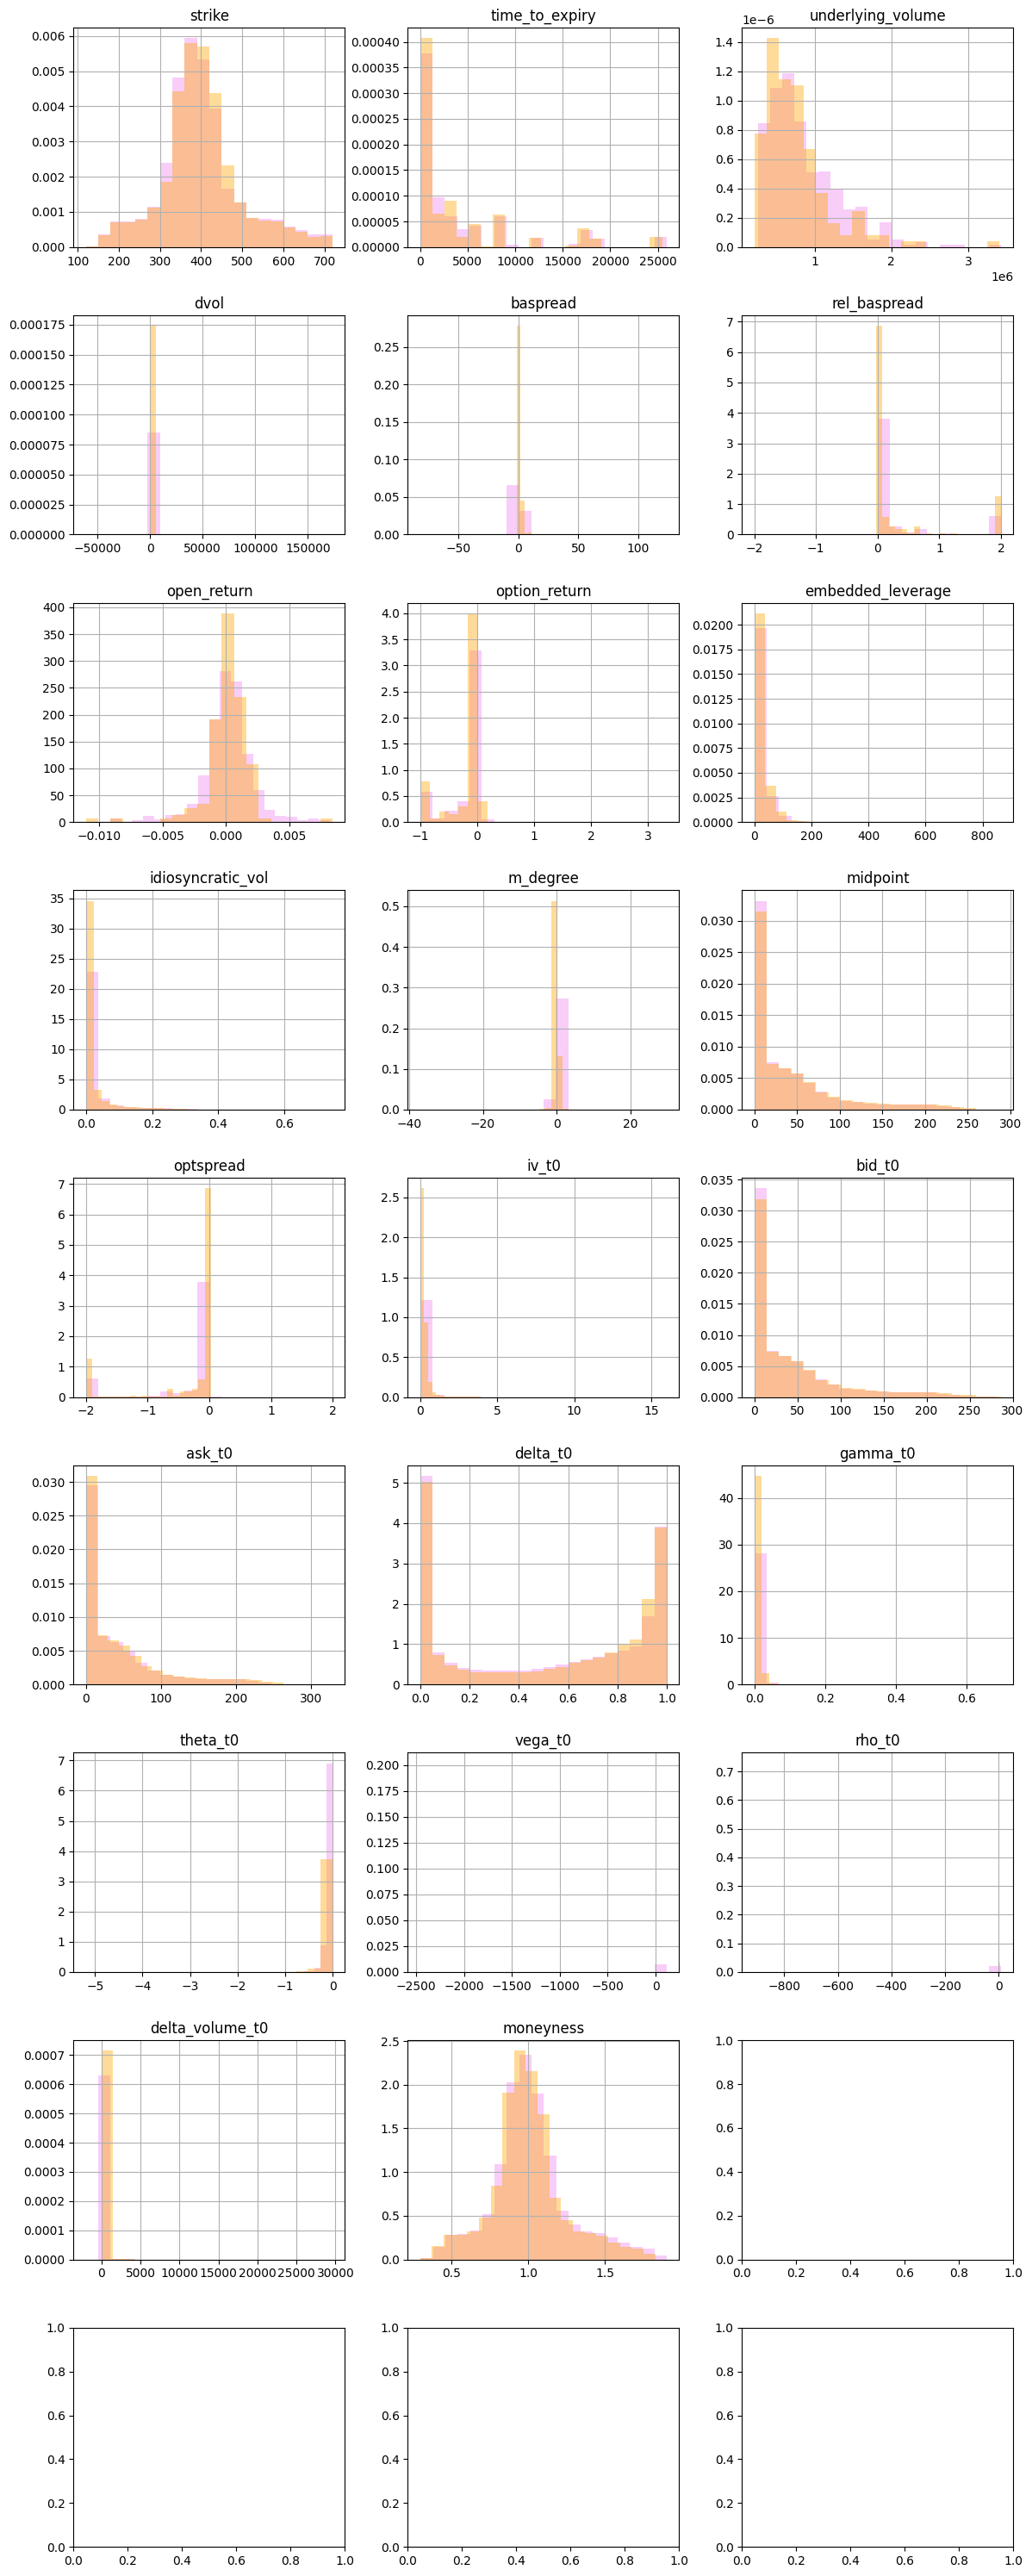

In [25]:
# observe features distribution between train and test set
cols_to_plot = [col for col in chosen_cols if ("datetime" not in col) and ("expire_date") not in col]
len_cols = len(cols_to_plot)
fig, ax = plt.subplots(len_cols // 3 + len_cols % 3, 3, figsize=(12, 30))
for col_idx, col in enumerate(cols_to_plot):
    idxrow, idxcol = col_idx // 3, col_idx % 3
    sub_feats_train[col].hist(bins=20, alpha=0.4, density=True, color="violet", ax=ax[idxrow][idxcol])
    sub_feats_test[col].hist(bins=20, alpha=0.4, density=True, color="orange", ax=ax[idxrow][idxcol])
    ax[idxrow][idxcol].set_title(col)
plt.tight_layout()

In [26]:
feats[["datetime", "open_return", "open_change_t0", "open_change_t-1", "open_change_t-2", "open_change_t-3"]].head(20)

,datetime,open_return,open_change_t0,open_change_t-1,open_change_t-2,open_change_t-3
0,2023-01-03 09:30:00,0.000000,0.000000,NaN,NaN,NaN
1,2023-01-03 09:45:00,0.002394,0.002394,0.000000,NaN,NaN
2,2023-01-03 10:00:00,-0.009136,-0.009136,0.002394,0.000000,NaN
3,2023-01-03 10:15:00,-0.001545,-0.001545,-0.009136,0.002394,0.000000
4,2023-01-03 10:30:00,-0.000761,-0.000761,-0.001545,-0.009136,0.002394
5,2023-01-03 10:45:00,0.000446,0.000446,-0.000761,-0.001545,-0.009136
6,2023-01-03 11:00:00,0.002598,0.002598,0.000446,-0.000761,-0.001545
7,2023-01-03 11:15:00,-0.006255,-0.006255,0.002598,0.000446,-0.000761
8,2023-01-03 11:30:00,0.001001,0.001001,-0.006255,0.002598,0.000446
9,2023-01-03 11:45:00,-0.002473,-0.002473,0.001001,-0.006255,0.002598


In [29]:
feats[[
    'datetime',
    'open_t-1',
    'open_slope_t_t-1',
    'open_slope_t_t-2',
    'open_slope_t_t-5',
    'open_slope_t_t-10',
    'open_slope_t_t-15'
]].head(20)

KeyError: "['open_t-1'] not in index"

In [30]:
[col for col in X_month.columns if "open" in col]

['open_return',
 'open_change_t0',
 'open_change_t-1',
 'open_change_t-2',
 'open_change_t-3',
 'open_change_t-4',
 'open_change_t-5',
 'open_change_t-6',
 'open_change_t-7',
 'open_change_t-8',
 'open_change_t-9',
 'open_change_t-10',
 'open_change_t-11',
 'open_change_t-12',
 'open_change_t-13',
 'open_change_t-14',
 'open_change_t-15',
 'open_slope_t_t-1',
 'open_slope_t_t-2',
 'open_slope_t_t-5',
 'open_slope_t_t-10',
 'open_slope_t_t-15']

In [29]:
[col for col in X_month.columns if "open" in col]

['open_return',
 'open_change_t0',
 'open_change_t-1',
 'open_change_t-2',
 'open_change_t-3',
 'open_change_t-4',
 'open_change_t-5',
 'open_change_t-6',
 'open_change_t-7',
 'open_change_t-8',
 'open_change_t-9',
 'open_change_t-10',
 'open_change_t-11',
 'open_change_t-12',
 'open_change_t-13',
 'open_change_t-14',
 'open_slope_t_t-1',
 'open_slope_t_t-2',
 'open_slope_t_t-5',
 'open_slope_t_t-10',
 'open_slope_t_t-15']

In [28]:
for col in cols_to_plot:
    ks_stat, p_val = ks_2samp(sub_feats_train[col], sub_feats_test[col])
    print(f"{col}: KS statistic = {ks_stat:.4f}, p-value = {p_val:.4f}")

strike: KS statistic = 0.0326, p-value = 0.0000
time_to_expiry: KS statistic = 0.0444, p-value = 0.0000
underlying_volume: KS statistic = 0.0933, p-value = 0.0000
dvol: KS statistic = 0.0049, p-value = 0.0000
baspread: KS statistic = 0.0277, p-value = 0.0000
rel_baspread: KS statistic = 0.0224, p-value = 0.0000
open_return: KS statistic = 0.0749, p-value = 0.0000
option_return: KS statistic = 0.0256, p-value = 0.0000
embedded_leverage: KS statistic = 0.0153, p-value = 0.0000
idiosyncratic_vol: KS statistic = 0.0683, p-value = 0.0000
m_degree: KS statistic = 0.0380, p-value = 0.0000
midpoint: KS statistic = 0.0235, p-value = 0.0000
optspread: KS statistic = 0.0224, p-value = 0.0000
iv_t0: KS statistic = 0.0815, p-value = 0.0000
bid_t0: KS statistic = 0.0238, p-value = 0.0000
ask_t0: KS statistic = 0.0232, p-value = 0.0000
delta_t0: KS statistic = 0.0400, p-value = 0.0000
gamma_t0: KS statistic = 0.0136, p-value = 0.0000
theta_t0: KS statistic = 0.0137, p-value = 0.0000
vega_t0: KS stati

In [38]:
for col in cols_to_plot:
    dist = wasserstein_distance(sub_feats_train[col], sub_feats_test[col])
    print(f"{col}: Wasserstein distance = {dist:.4f}")

strike: Wasserstein distance = 4.8447
time_to_expiry: Wasserstein distance = 194.1610
open_t0: Wasserstein distance = 10.9283
iv_t0: Wasserstein distance = 0.0146
bid_t0: Wasserstein distance = 2.8147
ask_t0: Wasserstein distance = 2.7681
delta_t0: Wasserstein distance = 0.0255
gamma_t0: Wasserstein distance = 0.0002
theta_t0: Wasserstein distance = 0.0028
vega_t0: Wasserstein distance = 0.9676
rho_t0: Wasserstein distance = 0.0179
volume_t0: Wasserstein distance = 23.6755
moneyness: Wasserstein distance = 0.0224


In [39]:
def js_divergence(x, y, bins=20):
    hist_x, _ = np.histogram(x, bins=bins, density=True)
    hist_y, _ = np.histogram(y, bins=bins, density=True)
    hist_x += 1e-8  # avoid zero probabilities
    hist_y += 1e-8
    hist_x /= hist_x.sum()
    hist_y /= hist_y.sum()
    return jensenshannon(hist_x, hist_y)

for col in cols_to_plot:
    jsd = js_divergence(sub_feats_train[col], sub_feats_test[col])
    print(f"{col}: Jensen-Shannon divergence = {jsd:.4f}")

strike: Jensen-Shannon divergence = 0.0388
time_to_expiry: Jensen-Shannon divergence = 0.0990
open_t0: Jensen-Shannon divergence = 0.2671
iv_t0: Jensen-Shannon divergence = 0.2790
bid_t0: Jensen-Shannon divergence = 0.0199
ask_t0: Jensen-Shannon divergence = 0.0782
delta_t0: Jensen-Shannon divergence = 0.0344
gamma_t0: Jensen-Shannon divergence = 0.0343
theta_t0: Jensen-Shannon divergence = 0.1462
vega_t0: Jensen-Shannon divergence = 0.8318
rho_t0: Jensen-Shannon divergence = 0.8179
volume_t0: Jensen-Shannon divergence = 0.0049
moneyness: Jensen-Shannon divergence = 0.0510
